In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV


In [3]:
# Load split datasets

# Load training data
X_train = pd.read_csv("../data/splits/X_train.csv")
y_train = pd.read_csv("../data/splits/y_train.csv")["vulnerability_score"]

# Load validation data
X_val = pd.read_csv("../data/splits/X_val.csv")
y_val = pd.read_csv("../data/splits/y_val.csv")["vulnerability_score"]

# Load test data (for final evaluation only)
X_test = pd.read_csv("../data/splits/X_test.csv")
y_test = pd.read_csv("../data/splits/y_test.csv")["vulnerability_score"]

print(f"Training set: {X_train.shape[0]:,} observations, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]:,} observations")
print(f"Test set: {X_test.shape[0]:,} observations")

# Get feature count
n_features = X_train.shape[1]
print(f"Features: {n_features}")


Training set: 16,933 observations, 65 features
Validation set: 3,628 observations
Test set: 3,629 observations
Features: 65


In [6]:
# Quick checks

# Check for missing values
missing_train = X_train.isnull().sum().sum()
missing_val = X_val.isnull().sum().sum()
missing_test = X_test.isnull().sum().sum()

print(
    f"Missing values - Train: {missing_train}, Val: {missing_val}, Test: {missing_test}"
)


Missing values - Train: 0, Val: 0, Test: 0


## Feature scaling for linear models

In [7]:
# Initialize scaler (fit only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

# Convert back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)


Feature scaling completed


## Strategic model selection

- Linear Regression: Simple baseline, interpretable coefficients
- Random Forest: Handles non-linearity, feature importance, robust  
- Gradient Boosting: Often best performance, handles complex patterns



In [9]:
# Model configuration setup
# Define models and their parameters
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "use_scaling": True,
        "params": {},
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "use_scaling": False,
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5],
        },
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "use_scaling": False,
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 5],
        },
    },
}


## Model training and validation

In [10]:
# Store results
results = {}
trained_models = {}

for model_name, config in models.items():
    print(f"\nTraining {model_name}...")

    # Select appropriate data (scaled or unscaled)
    if config["use_scaling"]:
        X_train_use = X_train_scaled_df
        X_val_use = X_val_scaled_df
    else:
        X_train_use = X_train
        X_val_use = X_val

    # Hyperparameter tuning with GridSearchCV
    if config["params"]:
        print(f"    Hyperparameter tuning...")
        grid_search = GridSearchCV(
            config["model"],
            config["params"],
            cv=5,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
        )
        grid_search.fit(X_train_use, y_train)
        best_model = grid_search.best_estimator_
        print(f"  Best parameters: {grid_search.best_params_}")
    else:
        # No hyperparameters to tune
        best_model = config["model"]
        best_model.fit(X_train_use, y_train)
        print(f"    No hyperparameters to tune")

    # Make predictions
    y_train_pred = best_model.predict(X_train_use)
    y_val_pred = best_model.predict(X_val_use)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    # Store results
    results[model_name] = {
        "train_mse": train_mse,
        "train_mae": train_mae,
        "train_r2": train_r2,
        "val_mse": val_mse,
        "val_mae": val_mae,
        "val_r2": val_r2,
        "overfitting": train_r2 - val_r2,
    }

    # Store trained model
    trained_models[model_name] = best_model

    print(f"  Training R²: {train_r2:.4f}")
    print(f"  Validation R²: {val_r2:.4f}")
    print(f"  Validation MAE: {val_mae:.2f}")
    print(f"  Overfitting: {train_r2 - val_r2:.4f}")



Training Linear Regression...
    No hyperparameters to tune
  Training R²: 0.3045
  Validation R²: 0.2942
  Validation MAE: 10.12
  Overfitting: 0.0103

Training Random Forest...
    Hyperparameter tuning...


/Users/issrar/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/issrar/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/issrar/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/issrar/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/issrar/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Us

  Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
  Training R²: 0.4514
  Validation R²: 0.2975
  Validation MAE: 10.14
  Overfitting: 0.1539

Training Gradient Boosting...
    Hyperparameter tuning...
  Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
  Training R²: 0.3611
  Validation R²: 0.3218
  Validation MAE: 9.96
  Overfitting: 0.0393


## Model comparison

In [11]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print("Model Performance Comparison:")
print("=" * 75)
print(
    f"{'Model':<18} {'Train R²':<10} {'Val R²':<10} {'Val MAE':<10} {'Overfitting':<12}"
)


for model_name in comparison_df.index:
    train_r2 = comparison_df.loc[model_name, "train_r2"]
    val_r2 = comparison_df.loc[model_name, "val_r2"]
    val_mae = comparison_df.loc[model_name, "val_mae"]
    overfitting = comparison_df.loc[model_name, "overfitting"]

    print(
        f"{model_name:<18} {train_r2:<10.4f} {val_r2:<10.4f} {val_mae:<10.2f} {overfitting:<12.4f}"
    )

# Identify best model
best_model_name = comparison_df["val_r2"].idxmax()
best_val_r2 = comparison_df.loc[best_model_name, "val_r2"]
best_val_mae = comparison_df.loc[best_model_name, "val_mae"]
best_overfitting = comparison_df.loc[best_model_name, "overfitting"]

print(f"\nBest model: {best_model_name}")
print(f"  Validation R²: {best_val_r2:.4f}")
print(f"  Validation MAE: {best_val_mae:.2f}")
print(f"  Overfitting: {best_overfitting:.4f}")


Model Performance Comparison:
Model              Train R²   Val R²     Val MAE    Overfitting 
Linear Regression  0.3045     0.2942     10.12      0.0103      
Random Forest      0.4514     0.2975     10.14      0.1539      
Gradient Boosting  0.3611     0.3218     9.96       0.0393      

Best model: Gradient Boosting
  Validation R²: 0.3218
  Validation MAE: 9.96
  Overfitting: 0.0393


## Model performance visualization

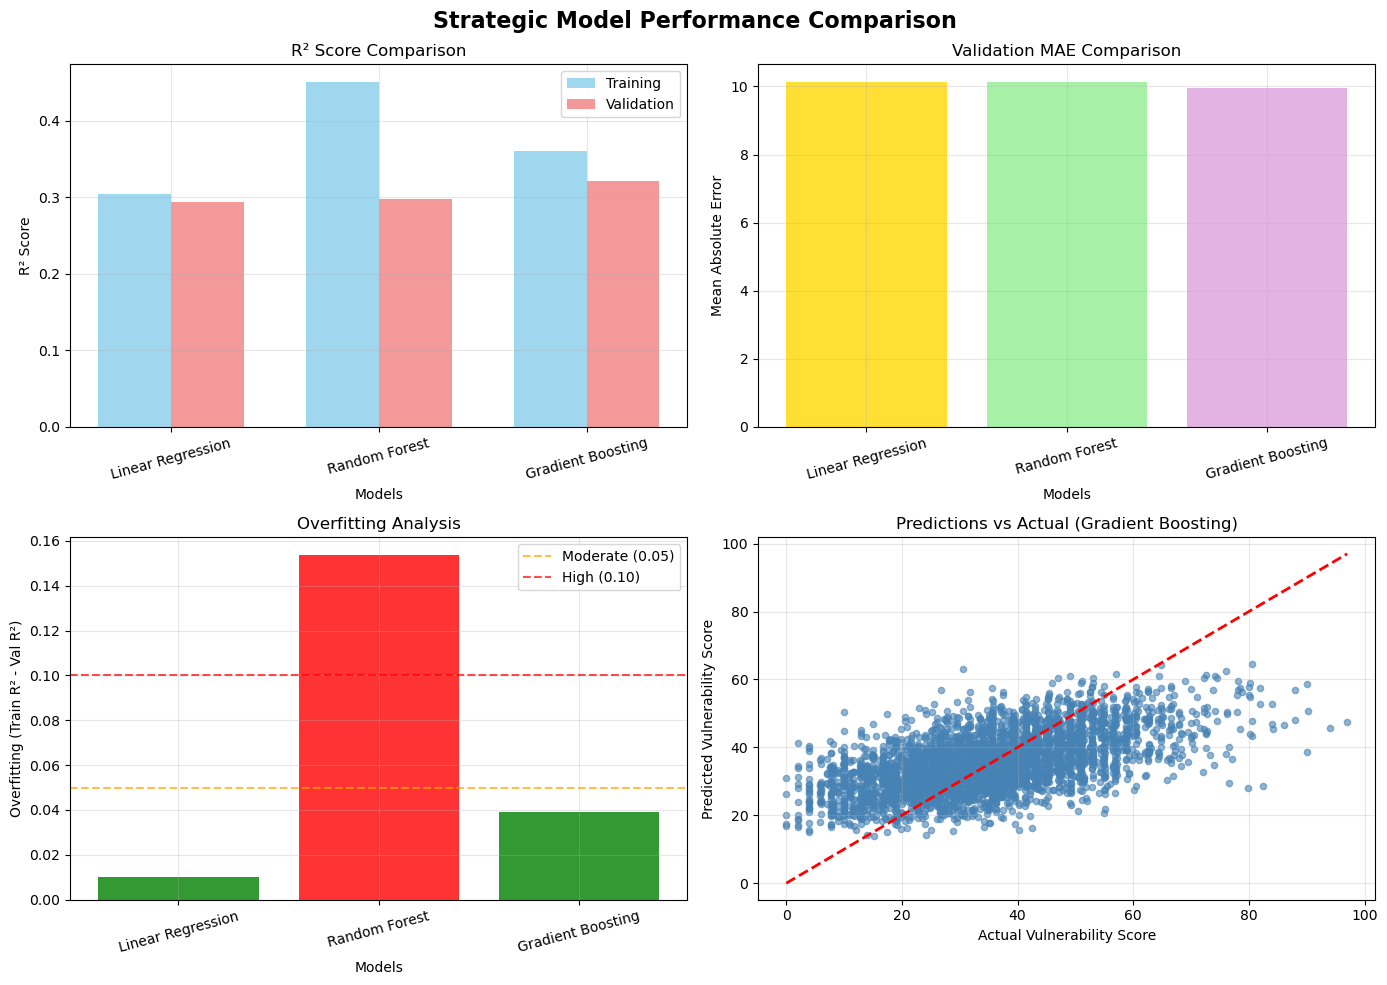

In [12]:
# Create performance visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Strategic Model Performance Comparison", fontsize=16, fontweight="bold")

# R² comparison
model_names = list(comparison_df.index)
train_r2_values = comparison_df["train_r2"].values
val_r2_values = comparison_df["val_r2"].values

x_pos = np.arange(len(model_names))
width = 0.35

axes[0, 0].bar(
    x_pos - width / 2,
    train_r2_values,
    width,
    label="Training",
    alpha=0.8,
    color="skyblue",
)
axes[0, 0].bar(
    x_pos + width / 2,
    val_r2_values,
    width,
    label="Validation",
    alpha=0.8,
    color="lightcoral",
)
axes[0, 0].set_xlabel("Models")
axes[0, 0].set_ylabel("R² Score")
axes[0, 0].set_title("R² Score Comparison")
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(model_names, rotation=15)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE comparison
val_mae_values = comparison_df["val_mae"].values
colors = ["gold", "lightgreen", "plum"]
axes[0, 1].bar(model_names, val_mae_values, color=colors, alpha=0.8)
axes[0, 1].set_xlabel("Models")
axes[0, 1].set_ylabel("Mean Absolute Error")
axes[0, 1].set_title("Validation MAE Comparison")
axes[0, 1].tick_params(axis="x", rotation=15)
axes[0, 1].grid(True, alpha=0.3)

# Overfitting analysis
overfitting_values = comparison_df["overfitting"].values
colors = [
    "red" if x > 0.1 else "orange" if x > 0.05 else "green" for x in overfitting_values
]
axes[1, 0].bar(model_names, overfitting_values, color=colors, alpha=0.8)
axes[1, 0].set_xlabel("Models")
axes[1, 0].set_ylabel("Overfitting (Train R² - Val R²)")
axes[1, 0].set_title("Overfitting Analysis")
axes[1, 0].tick_params(axis="x", rotation=15)
axes[1, 0].axhline(
    y=0.05, color="orange", linestyle="--", alpha=0.7, label="Moderate (0.05)"
)
axes[1, 0].axhline(y=0.1, color="red", linestyle="--", alpha=0.7, label="High (0.10)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Prediction scatter plot for best model
best_model = trained_models[best_model_name]
if models[best_model_name]["use_scaling"]:
    y_val_pred_best = best_model.predict(X_val_scaled_df)
else:
    y_val_pred_best = best_model.predict(X_val)

axes[1, 1].scatter(y_val, y_val_pred_best, alpha=0.6, color="steelblue", s=20)
axes[1, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--", lw=2)
axes[1, 1].set_xlabel("Actual Vulnerability Score")
axes[1, 1].set_ylabel("Predicted Vulnerability Score")
axes[1, 1].set_title(f"Predictions vs Actual ({best_model_name})")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Feature importance analysis

In [13]:
# Feature importance analysis for tree-based models
for model_name in ["Random Forest", "Gradient Boosting"]:
    if model_name in trained_models and hasattr(
        trained_models[model_name], "feature_importances_"
    ):
        print(f"\nTop 10 features - {model_name}:")
        print("-" * 40)

        feature_importance = trained_models[model_name].feature_importances_
        feature_names = X_train.columns

        # Create feature importance DataFrame
        importance_df = pd.DataFrame(
            {"feature": feature_names, "importance": feature_importance}
        ).sort_values("importance", ascending=False)

        for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
            print(f"{i + 1:2d}. {row['feature']:<35} {row['importance']:.4f}")



Top 10 features - Random Forest:
----------------------------------------
 1. total_media_channels                0.4034
 2. age                                 0.0937
 3. income_ordinal                      0.0459
 4. use_news_general_10+ times a day    0.0351
 5. use_news_general_2-5 times a day    0.0310
 6. use_news_general_once a day         0.0254
 7. use_news_general_6-10 times a day   0.0252
 8. gender_m                            0.0190
 9. use_news_sns_binary                 0.0177
10. traditional_media_count             0.0175

Top 10 features - Gradient Boosting:
----------------------------------------
 1. total_media_channels                0.4204
 2. use_news_general_2-5 times a day    0.0662
 3. age                                 0.0615
 4. income_ordinal                      0.0601
 5. use_news_general_10+ times a day    0.0531
 6. traditional_media_count             0.0383
 7. use_news_general_6-10 times a day   0.0318
 8. use_news_tvchannels_binary          0.0236


## Feature importance visualization

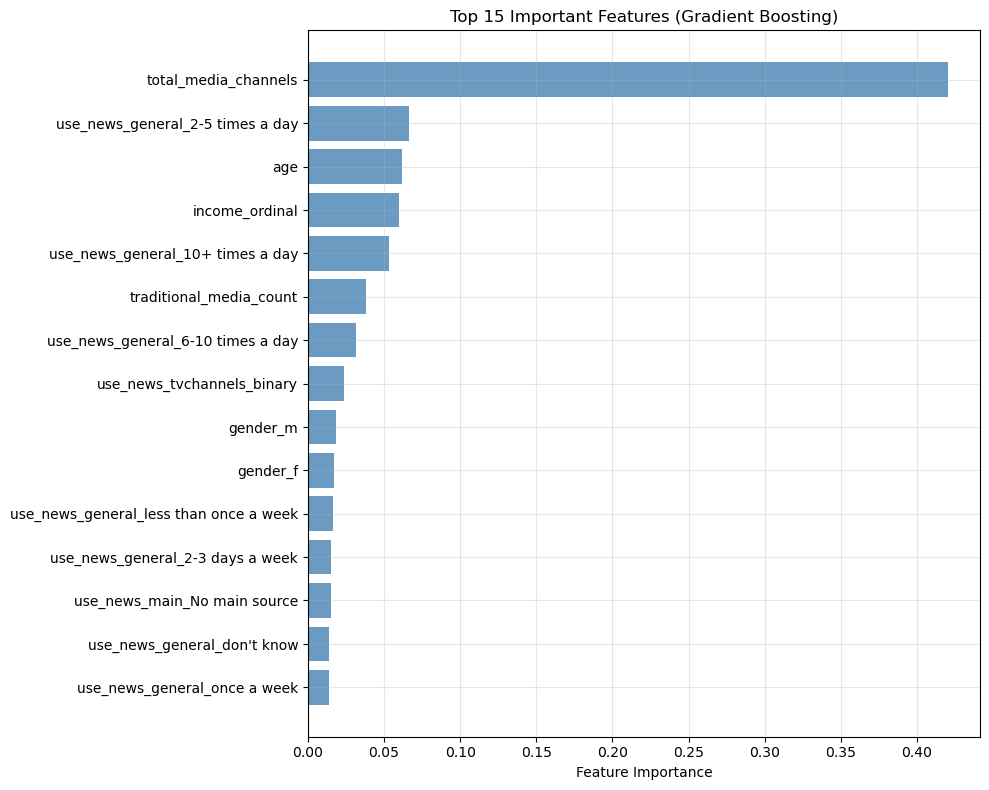

In [15]:
# Visualize feature importance for best model (Gradient Boosting)
feature_importance = trained_models[best_model_name].feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importance}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(
    range(len(top_features)), top_features["importance"], color="steelblue", alpha=0.8
)
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Feature Importance")
plt.title(f"Top 15 Important Features ({best_model_name})")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [17]:
# Model insights and interpretation

# Linear regression insights
linear_r2 = results["Linear Regression"]["val_r2"]
print(f"\nLinear Regression (R² = {linear_r2:.4f}):")
print(f"  Provides interpretable baseline performance")
print(f"  Assumes linear relationships between features and vulnerability")

# Random Forest insights
rf_r2 = results["Random Forest"]["val_r2"]
rf_improvement = rf_r2 - linear_r2
print(f"\nRandom Forest (R² = {rf_r2:.4f}):")
print(f"  Improvement over linear: {rf_improvement:+.4f}")
if rf_improvement > 0.05:
    print(f"  Significant non-linear patterns detected")
else:
    print(f"  Modest non-linear patterns")

# Gradient Boosting insights
gb_r2 = results["Gradient Boosting"]["val_r2"]
gb_improvement = gb_r2 - rf_r2
print(f"\nGradient Boosting (R² = {gb_r2:.4f}):")
print(f"  Improvement over Random Forest: {gb_improvement:+.4f}")
if gb_improvement > 0.02:
    print(f"  Complex patterns benefit from boosting")
else:
    print(f"  Diminishing returns from additional complexity")

# Overall assessment
best_r2 = max(linear_r2, rf_r2, gb_r2)
print(f"\nOverall assessment:")
if best_r2 > 0.4:
    print(f"  Strong predictive capability (R² > 0.4)")
elif best_r2 > 0.25:
    print(f"  Moderate predictive capability (R² > 0.25)")
else:
    print(f"  Limited predictive capability - consider feature engineering")



4.9 Model insights and interpretation
-----------------------------------
Strategic model comparison insights:

Linear Regression (R² = 0.2942):
  Provides interpretable baseline performance
  Assumes linear relationships between features and vulnerability

Random Forest (R² = 0.2975):
  Improvement over linear: +0.0033
  Modest non-linear patterns

Gradient Boosting (R² = 0.3218):
  Improvement over Random Forest: +0.0243
  Complex patterns benefit from boosting

Overall assessment:
  Moderate predictive capability (R² > 0.25)


In [18]:
# Final model evaluation on test set

print(f"Evaluating best model ({best_model_name}) on held-out test set...")

# Use appropriate data for best model
if models[best_model_name]["use_scaling"]:
    X_test_use = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
else:
    X_test_use = X_test

# Make predictions on test set
best_model = trained_models[best_model_name]
y_test_pred = best_model.predict(X_test_use)

# Calculate test metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTest Set Performance:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {np.sqrt(test_mse):.2f}")

# Compare with validation performance
val_r2 = results[best_model_name]["val_r2"]
val_mae = results[best_model_name]["val_mae"]

print(f"\nValidation vs Test Comparison:")
print(f"  Validation R²: {val_r2:.4f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Difference: {val_r2 - test_r2:+.4f}")
print(f"  Validation MAE: {val_mae:.2f}")
print(f"  Test MAE: {test_mae:.2f}")

# Performance consistency check
if abs(val_r2 - test_r2) < 0.02:
    print(f"\n Excellent consistency between validation and test performance")
elif abs(val_r2 - test_r2) < 0.05:
    print(f"\n Good consistency between validation and test performance")
else:
    print(f"\n Significant difference - possible overfitting to validation set")


Evaluating best model (Gradient Boosting) on held-out test set...

Test Set Performance:
  R² Score: 0.3365
  MAE: 9.79
  RMSE: 12.40

Validation vs Test Comparison:
  Validation R²: 0.3218
  Test R²: 0.3365
  Difference: -0.0146
  Validation MAE: 9.96
  Test MAE: 9.79

 Excellent consistency between validation and test performance


- Best Model: Gradient Boosting

- Final Test Performance:

    - R² Score: 0.3365 (33.7% variance explained)
    - Mean Absolute Error: 9.79 points
    - Model Reliability: Excellent (consistent validation/test)

- Key Findings:
    - Media channel diversity is the strongest predictor (42% importance)
    - Heavy news consumption increases vulnerability risk
    - Age and income are significant demographic factors
    - Traditional media consumption appears protective


## Model saving

In [21]:
import joblib

# Save the best model
model_filename = (
    f"../data/models/best_model_{best_model_name.lower().replace(' ', '_')}.pkl"
)
joblib.dump(trained_models[best_model_name], model_filename)
print(f"    Best model saved: {model_filename}")

# Save the scaler (needed for Linear Regression if it was best)
scaler_filename = "../data/models/feature_scaler.pkl"
joblib.dump(scaler, scaler_filename)
print(f"    Feature scaler saved: {scaler_filename}")

# Save all trained models
all_models_filename = "../data/models/all_trained_models.pkl"
joblib.dump(trained_models, all_models_filename)
print(f"    All models saved: {all_models_filename}")

# Save model results and metadata
results_filename = "../data/models/model_results.pkl"
model_metadata = {
    "results": results,
    "best_model_name": best_model_name,
    "feature_names": list(X_train.columns),
    "target_name": "vulnerability_score",
    "test_performance": {"r2": test_r2, "mae": test_mae, "rmse": np.sqrt(test_mse)},
}
joblib.dump(model_metadata, results_filename)
print(f"    Model metadata saved: {results_filename}")

# Save feature importance
importance_filename = "../data/models/feature_importance.pkl"
feature_importance_data = {
    "feature_names": list(X_train.columns),
    "importance_values": trained_models[best_model_name].feature_importances_,
    "model_name": best_model_name,
}
joblib.dump(feature_importance_data, importance_filename)


    Best model saved: ../data/models/best_model_gradient_boosting.pkl
    Feature scaler saved: ../data/models/feature_scaler.pkl
    All models saved: ../data/models/all_trained_models.pkl
    Model metadata saved: ../data/models/model_results.pkl


['../data/models/feature_importance.pkl']